# Problem Sheet 5
- To be completed by **12noon** on **Wednesday 6th November** and uploaded to [Problem Sheet 5 submission point](https://moodle.bath.ac.uk/mod/assign/view.php?id=1385492) on Moodle.

## Task (a): VC-dimension of the halfspaces classifier (lower bound)
Consider the halfspaces prediction rule in the homogeneous form,
$$
h_{\boldsymbol\theta}(\mathbf{x}) = \mathrm{sign}(\langle \boldsymbol\theta, \mathbf{x}\rangle) \in \mathcal{H}_n^{hs},
$$
where $\mathbf{x} = \begin{bmatrix}1\\ \mathbf{\hat x}\end{bmatrix}$, $\mathbf{\hat x} \in \mathbb{R}^n$, $\boldsymbol\theta \in \mathbb{R}^{n+1}.$
Consider a dataset 
$$
\mathbf{X} = \begin{bmatrix}\mathbf{x}_1 & \cdots & \mathbf{x}_{n+1} \end{bmatrix} = 
\begin{bmatrix}
1 & 1 & 1 & \cdots & 1 & 1 \\
0 & 1 & 0 & \cdots & 0 & 0 \\
0 & 0 & 1 & \cdots & 0 & 0 \\
\vdots & & & \ddots & & \vdots \\
0 & 0 & 0 & \cdots & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1
\end{bmatrix} \in \mathbb{R}^{(n+1) \times (n+1)}
$$
- Show that for any $y_1,\ldots,y_{n+1} \in \{-1,1\}$ you can find $\boldsymbol\theta$ such that $h_{\boldsymbol\theta}(\mathbf{x}_i) = y_i$, $i=1,\ldots,n+1$.

_Hint: you can solve the system of linear equations $\langle \boldsymbol\theta, \mathbf{x}_i\rangle = y_i$ exactly, so the $\mathrm{sign}()$ function is not needed in this case._

**Remark:** therefore, $\text{VC-dim}(\mathcal{H}_n^{hs}) \ge n+1$. In fact, one can prove that $\text{VC-dim}(\mathcal{H}_n^{hs}) = n+1$.

## Solution:
Multiplying $\boldsymbol\theta$ with columns of $\mathbf{X}$, we get
\begin{align*}
\langle \boldsymbol\theta, \mathbf{x}_1\rangle & = \theta_1 & = y_{1\phantom{+1}} \\
\langle \boldsymbol\theta, \mathbf{x}_2\rangle & = \theta_1 + \theta_2 & = y_{2\phantom{+1}} \\
& \vdots \\
\langle \boldsymbol\theta, \mathbf{x}_i\rangle & = \theta_1 + \theta_{i} & = y_{i\phantom{+1}} \\
& \vdots \\
\langle \boldsymbol\theta, \mathbf{x}_{n+1}\rangle & = \theta_1 + \theta_{n+1} & = y_{n+1}
\end{align*}
We can resolve this letting $\theta_1 = y_1$ and $\theta_i = y_i - \theta_1 = y_i - y_1$ for $i>1$ for any labels $y_1,\ldots,y_{n+1}$. Since the output is exactly $1$ or $-1$, the $\mathrm{sign}$ does not change it.

---

## Binary classification of Oxford temperature

### Warm-up

Here we want to predict whether the temperature in Oxford will be above or below 15 degrees Celsius in a given month. We choose a halfspaces prediction rule with polynomial features:
$$
h_{\boldsymbol\theta}(x) = \mathrm{sign}\left(\theta_0 + \theta_1 x + \cdots + \theta_n x^n - 15\right)
$$
where $x$ is the month, and $\boldsymbol\theta = (\theta_0,\ldots,\theta_n)$ is the vector of coefficients we will optimise. 

Here is the code as before reading the file `OxfordTemp.txt` for vectors of months `X` and temperatures `T`.

**Note that the temperatures are now stored in a variable `T`$=(t_1,\ldots,t_m)$, since $y_i$ will be the label $1$ if the temperature $t_i$ is above 15 degrees, and $-1$ otherwise.**

In [1]:
import numpy as np

D = np.loadtxt('OxfordTemp.txt')
X = D[:,0]
T = D[:,1]

Here is the rest of the code from the previous problem sheets. For simplicity, we will optimise the same loss function as before,
$$
L_{D}(\boldsymbol\theta) = \frac{1}{m}\sum_{i=1}^{m} (\theta_0 + \theta_1 x_i + \cdots + \theta_n x_i^n - t_i)^2,
$$
even though $\boldsymbol\theta^* = \arg\min L_{D}(\boldsymbol\theta)$ may not necessarily be the best **binary** classification parameter.

In [2]:
def features(x,n):
    powers = np.arange(n+1)               # [0,1,2,...,n]
    powers = np.reshape(powers, (1, -1))  # Make it explicitly a row vector
    x = np.reshape(x, (-1, 1))            # Make it explicitly a column vector
    return x**powers                      # Python automatically broadcasts the vectors to each others' shapes 
                                          # and takes the power between the resulting matrices elementwise

def optimise_loss(V,y):
    return np.linalg.solve(V.T @ V, V.T @ y)

def split_data(X,Y,K,k):
    # Create an index array, split that, and then take X and Y at this index array
    N = X.shape[0]
    test_range = range(k*N//K, (k+1)*N//K)  # index array of the test range
    Xtest = X[test_range]
    Xtrain = np.delete(X, test_range, axis=0)  # delete Xtest from X
    Ytest = Y[test_range]
    Ytrain = np.delete(Y, test_range, axis=0)  # delete Ytest from Y
    return Xtrain, Ytrain, Xtest, Ytest

## Task 1

- **Modify** the $K$-fold Cross Validation function below to train $\boldsymbol\theta^{(k)}$ still using the vector of temperatures and the sum-of-squares loss as above, **but** now the test losses counting the **number of wrong binary** labels:
  - $L_k:=\sum_{(x,t) \in D_{test}^{(k)}} |h_{\boldsymbol\theta^{(k)}}(x) - y(t)|/2$, where $y(t) = \mathrm{sign}(t-15)$.
  - Return $L_{cv} = \frac{1}{K} \sum_{k=0}^{K-1}L_k$

In [3]:
def cv(X,T,K,n):
    ind = np.arange(X.size)
    np.random.shuffle(ind)
    L = np.zeros(K)
    for k in range(K):
        Xtrain,Ttrain,Xtest,Ttest = split_data(X[ind],T[ind],K,k)
        V = features(Xtrain, n)
        theta_k = optimise_loss(V, Ttrain)
        V = features(Xtest, n)
        Ypred = np.sign(V @ theta_k - 15)
        Ytest = np.sign(Ttest - 15)
        L[k] = np.sum(np.abs(Ypred - Ytest)/2)
    return np.mean(L)

## Task 2:

- **Vary** $n$ from 1 to 10, and for each $n$ compute and **plot** the $4$-fold cross validation loss as a function of $n$.
- **Which** $n$ gives the smallest cross validation loss? How many wrong predictions you get on average?

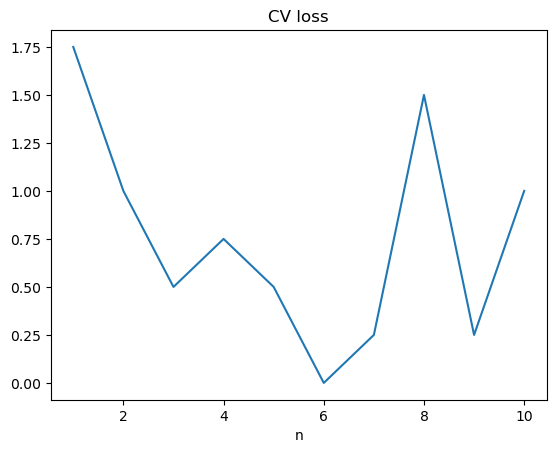

In [5]:
from matplotlib import pyplot as plt
cv_losses = [cv(X,T,4,n) for n in range(1, 11)]
plt.plot(range(1, 11), cv_losses)
plt.xlabel('n')
plt.title('CV loss')
plt.show()

The best $n$ is 6, which actually gives 0 loss (all correct predictions) in some realisations of the data splitting.